In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    roc_curve
)

sns.set(style="whitegrid")


In [22]:
df = pd.read_csv("../data/telco_churn.csv")

# Convert TotalCharges to numeric
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

# Fill missing values safely
df["TotalCharges"] = df["TotalCharges"].fillna(df["TotalCharges"].median())

# Drop ID column
df = df.drop(columns=["customerID"])

# Encode target
df["Churn"] = df["Churn"].map({"No": 0, "Yes": 1})

# Split features and target
X = df.drop("Churn", axis=1)
y = df["Churn"]

# Identify column types
categorical_cols = X.select_dtypes(include="object").columns
numerical_cols = X.select_dtypes(exclude="object").columns

# One-hot encoding
X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# Train-test split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scaling
scaler = StandardScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])


In [23]:
print("Train X:", X_train.shape)
print("Test X:", X_test.shape)
print("Train y:", y_train.shape)
print("Test y:", y_test.shape)


Train X: (5634, 30)
Test X: (1409, 30)
Train y: (5634,)
Test y: (1409,)


In [24]:
from sklearn.linear_model import LogisticRegression

log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train, y_train)

y_pred_log = log_model.predict(X_test)
y_prob_log = log_model.predict_proba(X_test)[:, 1]


In [25]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix
)

print("Logistic Regression Performance")
print("Accuracy :", accuracy_score(y_test, y_pred_log))
print("Precision:", precision_score(y_test, y_pred_log))
print("Recall   :", recall_score(y_test, y_pred_log))
print("F1 Score :", f1_score(y_test, y_pred_log))
print("ROC-AUC  :", roc_auc_score(y_test, y_prob_log))


Logistic Regression Performance
Accuracy : 0.8055358410220014
Precision: 0.6572327044025157
Recall   : 0.5588235294117647
F1 Score : 0.6040462427745664
ROC-AUC  : 0.8420057351003644


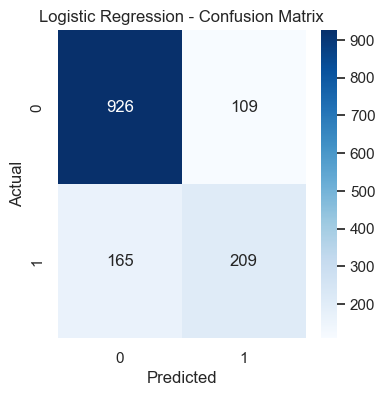

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_log)

plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Logistic Regression - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [27]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    class_weight="balanced"
)

rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]


In [28]:
print("Random Forest Performance")
print("Accuracy :", accuracy_score(y_test, y_pred_rf))
print("Precision:", precision_score(y_test, y_pred_rf))
print("Recall   :", recall_score(y_test, y_pred_rf))
print("F1 Score :", f1_score(y_test, y_pred_rf))
print("ROC-AUC  :", roc_auc_score(y_test, y_prob_rf))


Random Forest Performance
Accuracy : 0.7885024840312278
Precision: 0.6283783783783784
Recall   : 0.49732620320855614
F1 Score : 0.5552238805970149
ROC-AUC  : 0.8237541656978996


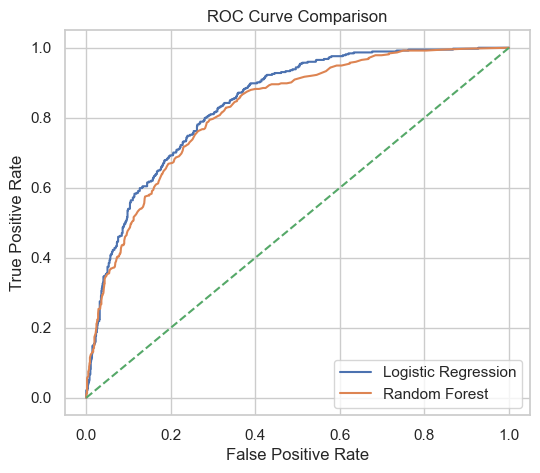

In [29]:
from sklearn.metrics import roc_curve

fpr_log, tpr_log, _ = roc_curve(y_test, y_prob_log)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)

plt.figure(figsize=(6,5))
plt.plot(fpr_log, tpr_log, label="Logistic Regression")
plt.plot(fpr_rf, tpr_rf, label="Random Forest")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()


In [30]:
import pandas as pd

feature_importance = pd.Series(
    rf_model.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)

feature_importance.head(10)


TotalCharges                      0.177273
tenure                            0.164566
MonthlyCharges                    0.151406
Contract_Two year                 0.059623
InternetService_Fiber optic       0.040754
PaymentMethod_Electronic check    0.035761
Contract_One year                 0.029983
OnlineSecurity_Yes                0.028859
gender_Male                       0.025542
PaperlessBilling_Yes              0.023940
dtype: float64

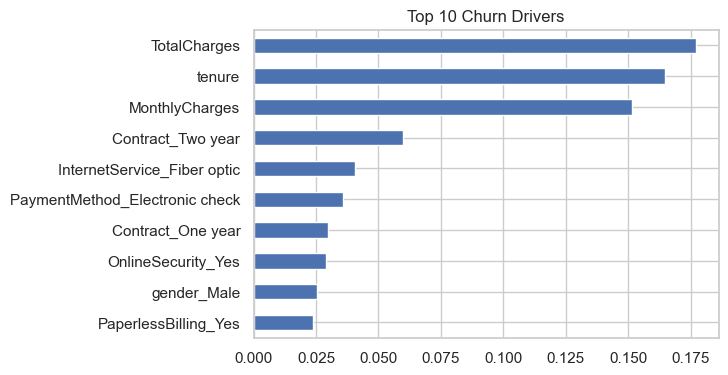

In [31]:
plt.figure(figsize=(6,4))
feature_importance.head(10).plot(kind="barh")
plt.gca().invert_yaxis()
plt.title("Top 10 Churn Drivers")
plt.show()


In [32]:
%pip install xgboost


Note: you may need to restart the kernel to use updated packages.


In [33]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    random_state=42
)

xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)
y_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]


In [34]:
print("XGBoost Performance")
print("Accuracy :", accuracy_score(y_test, y_pred_xgb))
print("Precision:", precision_score(y_test, y_pred_xgb))
print("Recall   :", recall_score(y_test, y_pred_xgb))
print("F1 Score :", f1_score(y_test, y_pred_xgb))
print("ROC-AUC  :", roc_auc_score(y_test, y_prob_xgb))


XGBoost Performance
Accuracy : 0.7934705464868701
Precision: 0.6325878594249201
Recall   : 0.5294117647058824
F1 Score : 0.5764192139737991
ROC-AUC  : 0.8356144565863236


In [35]:
results = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest", "XGBoost"],
    "Accuracy": [
        accuracy_score(y_test, y_pred_log),
        accuracy_score(y_test, y_pred_rf),
        accuracy_score(y_test, y_pred_xgb)
    ],
    "ROC-AUC": [
        roc_auc_score(y_test, y_prob_log),
        roc_auc_score(y_test, y_prob_rf),
        roc_auc_score(y_test, y_prob_xgb)
    ],
    "Recall": [
        recall_score(y_test, y_pred_log),
        recall_score(y_test, y_pred_rf),
        recall_score(y_test, y_pred_xgb)
    ]
})

results


,Model,Accuracy,ROC-AUC,Recall
0,Logistic Regression,0.805536,0.842006,0.558824
1,Random Forest,0.788502,0.823754,0.497326
2,XGBoost,0.793471,0.835614,0.529412


## Final Model Selection

Although advanced models like Random Forest and XGBoost were evaluated,
Logistic Regression achieved the highest ROC-AUC and recall.

Since the objective of churn prediction is to identify as many potential
churners as possible, recall was prioritized over accuracy.

Therefore, Logistic Regression was selected as the final model due to its
strong performance, stability, and interpretability.


In [36]:
import joblib

joblib.dump(log_model, "../models/logistic_regression_churn.pkl")
joblib.dump(scaler, "../models/scaler.pkl")

print("Final model and scaler saved successfully")


Final model and scaler saved successfully
